<a href="https://colab.research.google.com/github/punith-naga/ft/blob/main/Punith_Nagaraju_DeepLearning_segmentation_using_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Step 1: Import Libraries:**This section imports all necessary Python libraries for medical image processing, deep learning model building, and visualization. Key libraries include nibabel for NIfTI image handling, torch for deep learning, numpy for numerical operations, matplotlib for plotting, and segmentation_models_pytorch (smp) which provides implementations of popular segmentation architectures like UNet and DeepLabV3+.

In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
# %%
from IPython import get_ipython
from IPython.display import display
# %%
!pip install albumentations
!pip install nibabel
!pip install opencv-python
!pip install segmentation_models_pytorch # Includes UNet, DeepLabV3+, etc.
!pip install torch torchvision torchaudio
!pip install tensorflow # Keep if you need it for other parts, but not for these models

import nibabel as nib
from torch.utils.data import Dataset
import tensorflow as tf # Keep if needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

# Import models from segmentation_models_pytorch
import segmentation_models_pytorch as smp

print(f"Imports done")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
Imports done


**Step 2: Helper Functions and DataLoader:** This part of the notebook defines various helper functions crucial for the entire pipeline. It includes dice_loss and dice_score for metric calculation, visualization functions like plot_sample_colored and plot_sample_separate_modalities (adapted for 3D slices), and data manipulation utilities such as pad_or_crop_to_shape and safe_unsqueeze_mask. Most importantly, it defines the ISLESDataset3D class for loading and preprocessing 3D NIfTI medical images (DWI, ADC, and masks) and a pad_collate function to handle batching of variable-sized 3D volumes. It also introduces ensemble_predict and ensemble_predict_slice_by_slice functions for combining predictions from multiple models.



In [4]:
from google.colab import drive
drive.mount('/content/drive')
# 1. Set up paths and parameters

# Update DATA_DIR to use the path from kagglehub download.
# Assuming the downloaded dataset structure is LOCAL_DOWNLOAD_ROOT/isles-2022
# We need to construct the path to the 'isles-2022' subfolder within the downloaded root.
# Make sure `LOCAL_DOWNLOAD_ROOT` is defined from the previous cell.
# The actual path might vary, so adjust based on the exact structure after download.

# Assuming the dataset structure is like: /kaggle/input/orvile/isles-2022-brain-stoke-dataset/isles-2022
# Let's dynamically create this path.
if 'LOCAL_DOWNLOAD_ROOT' in globals():
    DATA_DIR = os.path.join(LOCAL_DOWNLOAD_ROOT, "isles-2022")
    print(f"Updated DATA_DIR to: {DATA_DIR}")
else:
    print("Warning: LOCAL_DOWNLOAD_ROOT not found. Falling back to default path.")
    DATA_DIR = "/content/drive/My Drive/ISLES" # Fallback if kagglehub.download wasn't executed

N_MODELS = 1 # Train 3 models for the ensemble
EPOCHS = 2 # Reduce epochs for testing, increase for proper training
BATCH_SIZE = 2 # Reduce batch size due to model complexity and 3D data
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_paths_dict = {}

print("Using :", DEVICE)
# ...existing code...

TARGET_SHAPE = (96, 96, 96)  # Increased target shape to prevent 1x1 feature maps after downsampling


# Helper functions (Your existing code)
def dice_loss(pred, target, smooth=1.):
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def dice_score(pred, target, smooth=1.):
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_sample(x, y, pred, channel=0):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input (selected channel)")
    plt.imshow(x[channel].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.show()


def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

# ...existing code...
def pad_or_crop_to_shape_2d(x, target_shape_2d):
    # x: [B, C, H, W]
    _, _, H, W = x.shape
    tH, tW = target_shape_2d
    # Pad
    pad_h_before = (tH - H) // 2
    pad_h_after = tH - H - pad_h_before
    pad_w_before = (tW - W) // 2
    pad_w_after = tW - W - pad_w_before

    # Padding order for F.pad is (W_left, W_right, H_top, H_bottom) for 4D
    x = F.pad(x, [pad_w_before, pad_w_after, pad_h_before, pad_h_after])

    # Crop (only if needed, padding should handle this)
    x = x[:, :, :tH, :tW]
    return x
# Make sure to include the pad_or_crop_to_shape helper function:
def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d_before = (tD - D) // 2
    pad_d_after = tD - D - pad_d_before
    pad_h_before = (tH - H) // 2
    pad_h_after = tH - H - pad_h_before
    pad_w_before = (tW - W) // 2
    pad_w_after = tW - W - pad_w_before

    # Padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
    x = F.pad(x, [pad_w_before, pad_w_after, pad_h_before, pad_h_after, pad_d_before, pad_d_after])

    # Crop (only if needed, padding should handle this)
    x = x[:, :, :tD, :tH, :tW]
    return x


# Evaluation Metrics (Add AVD and F1 score functions here - if you have them)
def absolute_volume_difference(pred, target):
    # Implement AVD calculation
    # Example (assuming pred and target are binary tensors):
    pred_volume = torch.sum(pred)
    target_volume = torch.sum(target)
    if target_volume == 0: # Avoid division by zero
        return float('inf') if pred_volume > 0 else 0.0
    avd = torch.abs(pred_volume - target_volume) / target_volume * 100
    return avd.item()


def lesion_wise_f1_score(pred, target):
    # Implement lesion-wise F1 score calculation
    # This requires identifying individual lesions. A common approach is
    # to use connected components analysis on the ground truth and predictions. Therefore requires libraries like SciPy or OpenCv.
    # For a simple pixel-wise F1, you can calculate that.

    # Simple pixel-wise F1:
    pred = pred.reshape(-1).bool()
    target = target.reshape(-1).bool()

    tp = (pred & target).sum().item()
    fp = (pred & ~target).sum().item()
    fn = (~pred & target).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1


def pad_or_crop_5d(x, target_shape):
    # x: [B, C, D, H, W] or [B, 1, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x


# ...existing code...

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

# %%
class ISLESDataset3D(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        print(f"entering 3D samples")
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")

                    # Look for both dwi and adc files in the dwi directory
                    dwi_files = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    adc_files = [f for f in os.listdir(dwi_dir) if f.endswith("_adc.nii.gz")]

                    flair_paths = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]

                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]

                    # Ensure all required files are found
                    if dwi_files and adc_files and flair_paths and mask_path:
                         # For this ensemble, we'll use DWI, ADC, and FLAIR as inputs (3 channels)
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_files[0]),
                            "adc": os.path.join(dwi_dir, adc_files[0]), # Add ADC path
                            "flair": os.path.join(anat_dir, flair_paths[0]), # Add FLAIR path
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total 3D samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi = self.load_nifti(sample["dwi"])    # [H, W, D]
        adc = self.load_nifti(sample["adc"])    # [H, W, D] - Load ADC
        flair = self.load_nifti(sample["flair"]) # [H, W, D] - Load FLAIR

        # Crop all to the minimum shape
        min_shape = np.minimum.reduce([dwi.shape, adc.shape, flair.shape])
        dwi_cropped = dwi[:min_shape[0], :min_shape[1], :min_shape[2]]
        adc_cropped = adc[:min_shape[0], :min_shape[1], :min_shape[2]]
        flair_cropped = flair[:min_shape[0], :min_shape[1], :min_shape[2]]


        x = np.stack([dwi_cropped, adc_cropped, flair_cropped], axis=0)  # Stack DWI, ADC, FLAIR [3, H, W, D]
        y = self.load_nifti(sample["mask"])
        y = y[:min_shape[0], :min_shape[1], :min_shape[2]]  # Crop mask to match


        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    @staticmethod
    def load_nifti(path):
        return np.asarray(nib.load(path).get_fdata(), dtype=np.float32)

# %%


def load_ensemble(model_paths_dict, device):
    models = []
    for model_name, paths in model_paths_dict.items():
         # Get config to recreate the model structure
        arch_name = model_name.split('_')[0] # Extract architecture name
        encoder_name = '_'.join(model_name.split('_')[1:]) # Extract encoder name

        for path in paths:
            try:
                 # Recreate the model structure
                 model = get_smp_model(
                    arch=arch_name,
                    encoder_name=encoder_name,
                    in_channels=3, # DWI, ADC, and FLAIR
                    out_classes=1  # Binary segmentation
                 ).to(device)

                 # Load the state dictionary
                 model.load_state_dict(torch.load(path, map_location=device))
                 model.eval() # Set model to evaluation mode
                 models.append(model)
                 print(f"Loaded {path}")
            except Exception as e:
                print(f"Error loading model from {path}: {e}")
                # Decide how to handle loading errors (e.g., skip the model)
                continue
    return models


# Helper functions for visualization (adapt if needed for 3D slices)
def plot_sample_colored(x, y, pred, channel=0, slice_idx=None):
    # Adapting for 3D: need to select a slice
    if x.ndim == 5: # [B, C, D, H, W]
        if slice_idx is None:
             slice_idx = x.shape[2] // 2 # Use middle slice if not specified
        img_slice = x[0, channel, slice_idx].cpu().squeeze() # Assuming batch size 1 for visualization
        y_slice = y[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, 1 channel for mask
        pred_slice = pred[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, 1 channel for prediction
    elif x.ndim == 4: # Assume [C, D, H, W] for single sample visualization
         if slice_idx is None:
             slice_idx = x.shape[1] // 2
         img_slice = x[channel, slice_idx].cpu().squeeze()
         y_slice = y[0, slice_idx].cpu().squeeze() # Assuming 1 channel for mask
         pred_slice = pred[0, slice_idx].cpu().squeeze() # Assuming 1 channel for prediction
    else:
        raise ValueError(f"Unsupported input shape for plotting: {x.shape}")


    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    img = img_slice
    img = (img - img.min()) / (img.max() - img.min() + 1e-8) # Normalize
    ax.imshow(img, cmap='gray')
    ax.imshow(y_slice, cmap='Greens', alpha=0.3)      # Ground truth in green
    ax.imshow(pred_slice, cmap='Reds', alpha=0.3)     # Prediction in red
    ax.set_title("Input + GT (green) + Pred (red)")
    ax.axis('off')
    plt.show()


def plot_sample_separate_modalities(x, y, pred, slice_idx=None):
        import matplotlib.pyplot as plt

        if x.ndim == 5: # [B, C, D, H, W]
            if slice_idx is None:
                 slice_idx = x.shape[2] // 2
            dwi_img_slice = x[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, DWI channel 0
            adc_img_slice = x[0, 1, slice_idx].cpu().squeeze() # Assuming batch size 1, ADC channel 1
            flair_img_slice = x[0, 2, slice_idx].cpu().squeeze() # Assuming batch size 1, FLAIR channel 2
            y_slice = y[0, 0, slice_idx].cpu().squeeze()
            pred_slice = pred[0, 0, slice_idx].cpu().squeeze()
        elif x.ndim == 4: # Assume [C, D, H, W] for single sample visualization
             if slice_idx is None:
                 slice_idx = x.shape[1] // 2
             dwi_img_slice = x[0, slice_idx].cpu().squeeze()
             adc_img_slice = x[1, slice_idx].cpu().squeeze()
             flair_img_slice = x[2, slice_idx].cpu().squeeze() # FLAIR channel 2
             y_slice = y[0, slice_idx].cpu().squeeze()
             pred_slice = pred[0, slice_idx].cpu().squeeze()
        else:
             raise ValueError(f"Unsupported input shape for plotting: {x.shape}")


        # Normalize for better visualization
        dwi_img_slice = (dwi_img_slice - dwi_img_slice.min()) / (dwi_img_slice.max() - dwi_img_slice.min() + 1e-8)
        adc_img_slice = (adc_img_slice - adc_img_slice.min()) / (adc_img_slice.max() - adc_img_slice.min() + 1e-8)
        flair_img_slice = (flair_img_slice - flair_img_slice.min()) / (flair_img_slice.max() - flair_img_slice.min() + 1e-8)


        # Plot DWI Input
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray')
        plt.title(f"Input (DWI) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot ADC Input
        plt.figure(figsize=(5, 5))
        plt.imshow(adc_img_slice, cmap='gray')
        plt.title(f"Input (ADC) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot FLAIR Input
        plt.figure(figsize=(5, 5))
        plt.imshow(flair_img_slice, cmap='gray')
        plt.title(f"Input (FLAIR) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot Ground Truth
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray') # Optionally show DWI in background
        plt.imshow(y_slice, cmap='Greens', alpha=0.3)
        plt.title(f"Ground Truth Mask (green) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot Prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray') # Optionally show DWI in background
        plt.imshow(pred_slice, cmap='Reds', alpha=0.3)
        plt.title(f"Prediction Mask (red) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()


def ensemble_predict(models, x, target_shape):
        with torch.no_grad():
            aligned_preds = []
            for i, model in enumerate(models):
                # Ensure model is on the correct device
                model.to(x.device)
                out = model(x) # Model predicts probabilities

                 # Ensure out is 5D [B, C, D, H, W] for pad_or_crop_to_shape
                while out.ndim < 5:
                    out = out.unsqueeze(0) # Add batch or channel dim if missing
                # Assuming smp models output [B, C, H, W] or similar, you'll need to adapt for 3D [B, C, D, H, W]
                # If smp models are strictly 2D, this approach needs significant modification
                # For 3D data, the output should also be 3D [B, C, D, H, W]

                # Pad/crop output to match target shape
                out_aligned = pad_or_crop_to_shape(out, target_shape)

                aligned_preds.append(out_aligned)

                # --- Add this print statement ---
                print(f"Model {i} output min/max:", out_aligned.min().item(), out_aligned.max().item())
                # --- End of print statement ---

        # Stack the aligned predictions from each model
        # All tensors in aligned_preds must have the same shape for stacking
        stacked = torch.stack(aligned_preds, dim=0) # Stacks along a new dimension (number of models)

        # Average the predictions across the models
        avg = torch.mean(stacked, dim=0)

        print("Averaged probabilities min/max:", avg.min().item(), avg.max().item())


        # Threshold the averaged probabilities to get the final binary mask
        final = (avg > 0.5).float() # Use a threshold, e.g., 0.5

        return final, avg # Return both the binary mask and averaged probabilities

# ...existing code...
import torch
import torch.nn.functional as F

def pad_collate(batch):
    xs, ys = zip(*batch)
    # print("Shapes of individual tensors in ys before padding:", [y.shape for y in ys]) # Keep for debugging if needed

    # Find max height, width, depth in this batch
    # individual tensors in xs are [C, D, H, W], ys are [D, H, W]
    max_d = max(x.shape[1] for x in xs) # Depth
    max_h = max(x.shape[2] for x in xs) # Height
    max_w = max(x.shape[3] for x in xs) # Width

    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        # x is [C, D, H, W], y is [D, H, W]

        # Padding needs to be calculated based on the current tensor's spatial dimensions
        pad_d = max_d - x.shape[1] # Pad in Depth
        pad_h = max_h - x.shape[2] # Pad in Height
        pad_w = max_w - x.shape[3] # Pad in Width

        # Padding order for F.pad is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
        # Applied to [C, D, H, W], it pads W, H, then D. For 4D tensor x: (W_left, W_right, H_top, H_bottom, D_front, D_back)
        x_padded = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d))
        # print("Shape of x_padded AFTER F.pad:", x_padded.shape) # Debug print

        # For y [D, H, W], padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back)
        y_padded = F.pad(y, (0, pad_w, 0, pad_h, 0, pad_d)) # This pads the 3D mask
        # print("Shape of y_padded AFTER F.pad:", y_padded.shape) # Debug print


        y_padded = y_padded.unsqueeze(0) # Add channel dim at index 0 [1, D, H, W]
        # print("Shape of y_padded AFTER unsqueeze:", y_padded.shape) # Debug print


        xs_padded.append(x_padded)
        ys_padded.append(y_padded)

    # --- Stack xs_padded here ---
    xs_padded = torch.stack(xs_padded, dim=0) # Stacks [C, D_p, H_p, W_p] to [B, C, D_p, H_p, W_p]
    # print("Shape of xs_padded AFTER stack:", xs_padded.shape) # Debug print
    # --- End of stacking xs_padded ---

    ys_padded = torch.stack(ys_padded, dim=0) # Stacks [1, D_p, H_p, W_p] to [B, 1, D_p, H_p, W_p]
    # print("Shape of ys_padded AFTER stack:", ys_padded.shape) # Debug print

    return xs_padded, ys_padded # Both are now stacked tensors

import torch.nn.functional as F

# %% Define ensemble_predict_slice_by_slice function
def ensemble_predict_slice_by_slice(models, x_3d, target_shape_3d):
    """
    Performs ensemble prediction on a 3D volume by processing it slice by slice.
    Each model in the ensemble is expected to be a 2D segmentation model.

    Args:
        models (list): A list of trained 2D PyTorch segmentation models.
        x_3d (torch.Tensor): The input 3D volume batch, shape [B, C, D, H, W].
        target_shape_3d (tuple): The target spatial shape (D, H, W) for the output mask.

    Returns:
        tuple: A tuple containing:
            - final_ensemble_mask (torch.Tensor): The final binary 3D mask after averaging,
              shape [B, 1, D, H, W].
            - averaged_probs_3d (torch.Tensor): The averaged 3D probability map,
              shape [B, 1, D, H, W].
    """
    if not models:
        print("No models provided for ensemble prediction.")
        return None, None

    # Determine batch size, channels, and depth from input
    batch_size, num_channels, depth, height, width = x_3d.shape
    device = x_3d.device

    all_models_slice_outputs = [] # To store list of 3D tensors [B, 1, D, H, W]

    with torch.no_grad():
        for model_idx, model in enumerate(models):
            model.eval() # Ensure model is in evaluation mode
            model_3d_output_probs = torch.zeros(
                (batch_size, 1, target_shape_3d[0], target_shape_3d[1], target_shape_3d[2]),
                device=device, dtype=torch.float32
            )

            for d in range(depth): # Iterate through each slice (depth)
                x_slice_2d = x_3d[:, :, d, :, :] # Extract 2D slice: [B, C, H, W]

                # Padding for divisibility (as done in training)
                required_divisor = 32 # Assuming this is consistent for all models
                h_slice, w_slice = x_slice_2d.shape[2:]
                new_h = (h_slice + required_divisor - 1) // required_divisor * required_divisor
                new_w = (w_slice + required_divisor - 1) // required_divisor * required_divisor
                target_padded_shape_2d = (new_h, new_w)

                x_slice_padded = pad_or_crop_to_shape_2d(x_slice_2d, target_padded_shape_2d)

                # Get prediction from current model for the current slice
                model_pred_2d = model(x_slice_padded) # Output: [B, 1, H_padded, W_padded] (logits or raw output)
                model_pred_2d = torch.sigmoid(model_pred_2d) # Apply sigmoid to get probabilities

                # Align back to the original slice's spatial dimensions (H, W) or target for padding
                # If target_shape_3d is used, the spatial shape for the slice is target_shape_3d[1:]
                target_spatial_shape_slice = target_shape_3d[1:] # (H, W)
                model_pred_2d_aligned = pad_or_crop_to_shape_2d(model_pred_2d, target_spatial_shape_slice)

                # Ensure channel dimension is 1
                if model_pred_2d_aligned.shape[1] != 1:
                    model_pred_2d_aligned = model_pred_2d_aligned[:, :1, :, :] # Take the first channel

                # Insert the processed 2D slice prediction into the 3D tensor
                # Ensure dimensions match: model_3d_output_probs is [B, 1, D_target, H_target, W_target]
                # model_pred_2d_aligned is [B, 1, H_target, W_target] (for this slice)
                # Need to check if the current slice `d` aligns with D_target
                if d < target_shape_3d[0]:
                    model_3d_output_probs[:, :, d, :, :] = model_pred_2d_aligned


            all_models_slice_outputs.append(model_3d_output_probs)

    # Stack all 3D probability outputs from each model
    # Shape will be [num_models, B, 1, D, H, W]
    stacked_model_probs = torch.stack(all_models_slice_outputs, dim=0)

    # Average the probabilities across the models (dimension 0)
    # Resulting shape: [B, 1, D, H, W]
    averaged_probs_3d = torch.mean(stacked_model_probs, dim=0)

    # Threshold to get the final binary mask
    final_ensemble_mask = (averaged_probs_3d > 0.5).float()

    print("Averaged probabilities min/max:", averaged_probs_3d.min().item(), averaged_probs_3d.max().item())

    return final_ensemble_mask, averaged_probs_3d


# Helper function to get models from smp
def get_smp_model(arch, encoder_name, in_channels, out_classes):
    if arch == "unet":
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet", # You can use pre-trained weights if available for the encoder
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5, # Adjust encoder depth if needed
            decoder_channels=[256, 128, 64, 32, 16] # Adjust decoder channels if needed
        )
    elif arch == "unetplusplus":
         model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_output_stride=16 # Common setting for DeeplabV3+
        )
    elif arch == "linknet":
         model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes
        )
    else:
        raise ValueError(f"Unsupported architecture from smp: {arch}")

    return model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using : cuda


**Step 3: Data Loading and Training (Bagging Ensemble)**: This section initiates the data loading process by creating an instance of ISLESDataset3D and a DataLoader. It then sets up the training loop for multiple base models (UNet, DeepLabV3+, UNetPlusPlus, LinkNet with various ResNet encoders) as part of a 'Bagging' ensemble approach. Each model is trained independently, slice-by-slice, on the available 3D data. The notebook handles padding of 2D slices to ensure divisibility by the model's required stride and saves the state dictionary of each trained model.

In [3]:

# %% Data Loading
train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set to 0 for Colab, higher on systems with multiprocessing
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

# %% Model Definitions using segmentation_models_pytorch


# Define the model architectures and their configurations for the ensemble
# Using popular backbones from torchvision suitable for segmentation tasks
model_architectures = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    # "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"}, # Removed due to persistent 1x1 error
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    # You can add more or different models here
    # "unet_resnet34": {"arch": "unet", "encoder_name": "resnet34"},
     "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}

# %% Training
print(f"#Train multiple base models for ensemble")


# ... previous imports and setup ...

for model_name, config in model_architectures.items():
    arch_name = config["arch"]
    encoder_name = config["encoder_name"]

    model_paths_dict[model_name] = []
    for i in range(N_MODELS):
        print(f"Training {model_name} model {i+1}/{N_MODELS}, epoch 1/{EPOCHS}")

        # Get the 2D model from smp
        try:
             # Note: input channels is now 3 (DWI + ADC + FLAIR), output classes is 1
             # The model expects 2D input [B, C, H, W]
             model = get_smp_model(
                 arch=arch_name,
                 encoder_name=encoder_name,
                 in_channels=3,
                 out_classes=1
             ).to(DEVICE)
        except Exception as e:
            print(f"Error creating {model_name}: {e}")
            continue # Skip to the next model if creation fails

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = dice_loss # Still using Dice Loss

        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
                # x_3d is [B, C, D, H, W]
                # y_3d is [B, 1, D, H, W]

                # Process slice by slice
                batch_losses = []
                for d in range(x_3d.shape[2]): # Iterate through depth dimension
                    x_slice = x_3d[:, :, d, :, :].to(DEVICE, dtype=torch.float) # Get 2D slice [B, C, H, W]
                    y_slice = y_3d[:, :, d, :, :].to(DEVICE, dtype=torch.float) # Get 2D mask slice [B, 1, H, W]

                    # --- Add padding to make height and width divisible by the required divisor and ensure minimum size ---
                    required_divisor = 32
                    h, w = x_slice.shape[2:]
                    min_spatial_dim_for_bn = 128 # Increased to 128 to ensure larger feature maps and avoid 1x1 error

                    new_h = max(min_spatial_dim_for_bn, (h + required_divisor - 1) // required_divisor * required_divisor)
                    new_w = max(min_spatial_dim_for_bn, (w + required_divisor - 1) // required_divisor * required_divisor)
                    target_padded_shape_slice = (new_h, new_w)

                    # Use pad_or_crop_to_shape_2d to pad the input slice
                    x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                    # Also pad the target mask slice to match the padded input slice's spatial shape
                    y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)
                    # --- End of padding ---


                    optimizer.zero_grad()
                    out_slice = model(x_slice_padded) # Use the padded slice as input

                    # Now, 'out_slice' has spatial dimensions related to 'target_padded_shape_slice'
                    # We need to align 'out_slice' with the original (or padded by pad_collate)
                    # spatial shape of 'y_slice' for loss calculation.
                    # The 'y_slice' already has spatial dimensions from the original padding in pad_collate.
                    # So, align 'out_slice' to 'y_slice' spatial shape.

                    target_spatial_shape_slice_for_loss = y_slice.shape[2:] # Original slice shape (H, W)
                    # Ensure out_slice is 4D [B, C, H, W] before padding/cropping
                    while out_slice.ndim < 4:
                         out_slice = out_slice.unsqueeze(0)

                    out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                    # Ensure both tensors have the same spatial dimensions for loss calculation
                    # Use min of spatial dimensions for robust comparison/loss calculation
                    min_h_loss = min(out_slice_aligned_for_loss.shape[2], y_slice_padded.shape[2])
                    min_w_loss = min(out_slice_aligned_for_loss.shape[3], y_slice_padded.shape[3])

                    out_slice_aligned_for_loss = out_slice_aligned_for_loss[:, :, :min_h_loss, :min_w_loss]
                    y_slice_padded = y_slice_padded[:, :, :min_h_loss, :min_w_loss]


                    loss = criterion(out_slice_aligned_for_loss, y_slice_padded) # Calculate loss using the aligned output and padded target
                    loss.backward()
                    batch_losses.append(loss.item())

                # ... rest of the batch loop ...

                # ... rest of the batch loop ...

                # After processing all slices in the batch, step the optimizer
                optimizer.step()
                total_loss += np.mean(batch_losses) # Average loss across slices for the batch

                print(f"  {model_name} Model {i+1} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

        print(f"Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

        # Save the trained model
    save_path = f"/content/drive/My Drive/{model_name}_new_model_{i}.pth"
    torch.save(model.state_dict(), save_path)
    model_paths_dict[model_name].append(save_path)
    print(f"Saved {save_path}")

entering 3D samples
Total 3D samples: 49
Number of samples in dataset: 49
Number of batches in DataLoader: 25
#Train multiple base models for ensemble
Training unet_resnet18 model 1/1, epoch 1/1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

  unet_resnet18 Model 1 Epoch 1 Batch 0/25 Avg Slice Loss: 1.0001
  unet_resnet18 Model 1 Epoch 1 Batch 1/25 Avg Slice Loss: 0.9974
  unet_resnet18 Model 1 Epoch 1 Batch 2/25 Avg Slice Loss: 0.9994
  unet_resnet18 Model 1 Epoch 1 Batch 3/25 Avg Slice Loss: 1.0001
  unet_resnet18 Model 1 Epoch 1 Batch 4/25 Avg Slice Loss: 0.9352
  unet_resnet18 Model 1 Epoch 1 Batch 5/25 Avg Slice Loss: 0.9936
  unet_resnet18 Model 1 Epoch 1 Batch 6/25 Avg Slice Loss: 0.9996
  unet_resnet18 Model 1 Epoch 1 Batch 7/25 Avg Slice Loss: 0.9967
  unet_resnet18 Model 1 Epoch 1 Batch 8/25 Avg Slice Loss: 0.9998
  unet_resnet18 Model 1 Epoch 1 Batch 9/25 Avg Slice Loss: 0.9994
  unet_resnet18 Model 1 Epoch 1 Batch 10/25 Avg Slice Loss: 1.0001
  unet_resnet18 Model 1 Epoch 1 Batch 11/25 Avg Slice Loss: 0.9999
  unet_resnet18 Model 1 Epoch 1 Batch 12/25 Avg Slice Loss: 0.9973
  unet_resnet18 Model 1 Epoch 1 Batch 13/25 Avg Slice Loss: 0.9953
  unet_resnet18 Model 1 Epoch 1 Batch 14/25 Avg Slice Loss: 0.9841
  une

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

  unetplusplus_resnet34 Model 1 Epoch 1 Batch 0/25 Avg Slice Loss: 0.9971
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 1/25 Avg Slice Loss: 0.9964
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 2/25 Avg Slice Loss: 0.9996
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 3/25 Avg Slice Loss: 0.9996
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 4/25 Avg Slice Loss: 0.9976
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 5/25 Avg Slice Loss: 0.9999
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 6/25 Avg Slice Loss: 0.9999
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 7/25 Avg Slice Loss: 1.0026
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 8/25 Avg Slice Loss: 0.9992
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 9/25 Avg Slice Loss: 0.9795
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 10/25 Avg Slice Loss: 1.0004
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 11/25 Avg Slice Loss: 0.9996
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 12/25 Avg Slice Loss: 1.0001
  unetplusplus_resnet34 Model 1 Epo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Step 4: Load Bagging Ensemble Models and Perform Prediction**: After training, this section focuses on loading the saved state dictionaries of all the individual models trained in the Bagging phase. It then demonstrates how to perform an ensemble prediction on a new batch of data by passing the data through each loaded model slice-by-slice, applying sigmoid to get probabilities, and then averaging these probabilities across all models. The final averaged prediction mask is thresholded (e.g., at 0.5) to get a binary segmentation, and visualizations are generated for a specific slice that contains a ground truth lesion.

# Loading All Trained Models from model_paths_dict for Ensemble Prediction
model_paths_dict after assignment:
{'unet_resnet18': ['/content/drive/My Drive/unet_resnet18_new_model_0.pth'], 'unetplusplus_resnet34': ['/content/drive/My Drive/unetplusplus_resnet34_new_model_0.pth'], 'deeplabv3plus_resnet50': ['/content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth'], 'linknet_resnet18': ['/content/drive/My Drive/linknet_resnet18_new_model_0.pth']}
entering 3D samples
Total 3D samples: 49
Loading models for: unet_resnet18
Loaded model from /content/drive/My Drive/unet_resnet18_new_model_0.pth
Loading models for: unetplusplus_resnet34
Loaded model from /content/drive/My Drive/unetplusplus_resnet34_new_model_0.pth
Loading models for: deeplabv3plus_resnet50


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Error loading model from /content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth: [Errno 2] No such file or directory: '/content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth'
Loading models for: linknet_resnet18
Loaded model from /content/drive/My Drive/linknet_resnet18_new_model_0.pth
Total models loaded for ensemble prediction: 3
# Ensemble prediction on a batch and visualization (using all loaded models)
Input batch min/max: tensor(-13.6557) tensor(2056.6870)
Mask batch unique values: tensor([0., 1.])
Averaged probabilities min/max: 3.102368073104646e-26 1.0
Searching for a slice with a mask in sample 0...
Found slice with mask at depth index: 60
Plotting results for sample 0, using slice with mask: 60


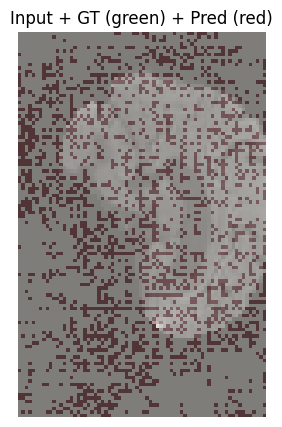

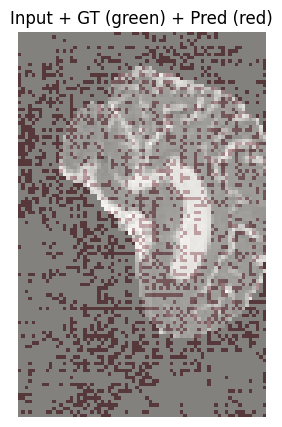

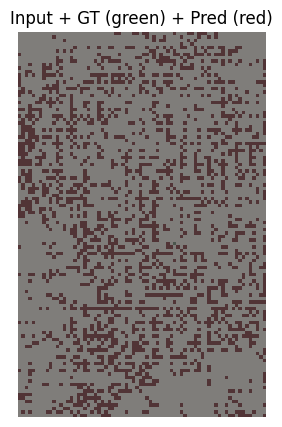

In [5]:

# **Step 5: Load All Trained Models and Perform Ensemble Prediction**
# %%
print(f"# Loading All Trained Models from model_paths_dict for Ensemble Prediction")

# Helper function to get models from smp
def get_smp_model(arch, encoder_name, in_channels, out_classes):
    if arch == "unet":
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "unetplusplus":
         model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_output_stride=16
        )
    elif arch == "linknet":
         model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes
        )
    else:
        raise ValueError(f"Unsupported architecture from smp: {arch}")

    return model
model_architectures = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"},
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    # You can add more or different models here
    # "unet_resnet34": {"arch": "unet", "encoder_name": "resnet34"},
     "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}
# Define the base path to your Google Drive
DRIVE_PATH = "/content/drive/My Drive/"

# Initialize model_paths_dict if it doesn't exist
if 'model_paths_dict' not in globals():
    model_paths_dict = {}

# Assign the specified model paths to model_paths_dict
model_paths_dict["unet_resnet18"] = [os.path.join(DRIVE_PATH, "unet_resnet18_new_model_0.pth")]
model_paths_dict["unetplusplus_resnet34"] = [os.path.join(DRIVE_PATH, "unetplusplus_resnet34_new_model_0.pth")]
model_paths_dict["deeplabv3plus_resnet50"] = [os.path.join(DRIVE_PATH, "deeplabv3plus_resnet50_new_model_0.pth")]
model_paths_dict["linknet_resnet18"] = [os.path.join(DRIVE_PATH, "linknet_resnet18_new_model_0.pth")]

# You can print the dictionary to verify
print("model_paths_dict after assignment:")
print(model_paths_dict)
all_loaded_models = []
train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set to 0 for Colab, higher on systems with multiprocessing
    collate_fn=pad_collate
)

import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch

# Iterate through the model_paths_dict to load models from all categories
# This assumes model_paths_dict is populated from previous training steps.
if 'model_paths_dict' not in globals() or not model_paths_dict:
     print("Error: 'model_paths_dict' is not populated. Please ensure models were trained and saved.")
else:
    for model_name, paths in model_paths_dict.items():
        print(f"Loading models for: {model_name}")
        if model_name not in model_architectures:
             print(f"Warning: Configuration for '{model_name}' not found in model_architectures. Cannot recreate model structure. Skipping.")
             continue

        config = model_architectures[model_name]
        arch_name = config["arch"]
        encoder_name = config["encoder_name"]

        for path in paths:
            try:
                # Recreate the model structure using the retrieved config
                model = get_smp_model(
                     arch=arch_name,
                     encoder_name=encoder_name,
                     in_channels=3, # DWI, ADC and FLAIR
                     out_classes=1  # Binary segmentation
                ).to(DEVICE)
                # Load the state dictionary
                model.load_state_dict(torch.load(path, map_location=DEVICE))
                model.eval() # Set model to evaluation mode
                all_loaded_models.append(model)
                print(f"Loaded model from {path}")
            except Exception as e:
                print(f"Error loading model from {path}: {e}")
                continue # Skip loading this model if there's an error

print(f"Total models loaded for ensemble prediction: {len(all_loaded_models)}")

# **Step 6: Ensemble Prediction and Visualization**
# %%
print(f"# Ensemble prediction on a batch and visualization (using all loaded models)")

# Get a batch from the DataLoader for prediction
try:
    x_batch, y_batch = next(iter(train_loader)) # Use generic names as it's for combined ensemble
except StopIteration:
    print("No data in train_loader. Check dataset or batch size.")
    x_batch, y_batch = None, None

if x_batch is not None and all_loaded_models: # Ensure data and models are available
    print("Input batch min/max:", x_batch.min(), x_batch.max())
    print("Mask batch unique values:", torch.unique(y_batch))

    x_batch = x_batch.to(DEVICE, dtype=torch.float)
    y_batch = y_batch.to(DEVICE, dtype=torch.float)

    target_spatial_shape_3d = y_batch.shape[2:]

    # Perform ensemble prediction using all loaded models
    final_ensemble_mask, averaged_ensemble_probs = ensemble_predict_slice_by_slice(all_loaded_models, x_batch, target_spatial_shape_3d)

    if final_ensemble_mask is not None:
        sample_index_to_plot = 0 # Choose which sample in the batch to plot
        dwi_channel = 0
        adc_channel = 1
        flair_channel = 2 # Added FLAIR channel

        # --- Find a slice with a mask ---
        slice_index_with_mask = None
        # Assuming y_batch is [B, 1, D, H, W]
        ground_truth_volume = y_batch[sample_index_to_plot, 0] # Get the 3D mask for the sample [D, H, W]

        print(f"Searching for a slice with a mask in sample {sample_index_to_plot}...")
        for d in range(ground_truth_volume.shape[0]): # Iterate through depth
            mask_slice = ground_truth_volume[d]
            if torch.sum(mask_slice) > 0: # Check if there are any non-zero pixels in the slice
                slice_index_with_mask = d
                print(f"Found slice with mask at depth index: {slice_index_with_mask}")
                break # Stop searching once a slice with a mask is found

        if slice_index_with_mask is not None:
            slice_index_to_plot = slice_index_with_mask
            print(f"Plotting results for sample {sample_index_to_plot}, using slice with mask: {slice_index_to_plot}")

            # Plotting DWI input, GT, and Ensemble Prediction for the found slice
            plot_sample_colored(
                x_batch[sample_index_to_plot],
                y_batch[sample_index_to_plot],
                final_ensemble_mask[sample_index_to_plot],
                channel=dwi_channel,
                slice_idx=slice_index_to_plot
            )

            # Optionally, plot ADC input, GT, and Ensemble Prediction as well
            plot_sample_colored(
                x_batch[sample_index_to_plot],
                y_batch[sample_index_to_plot],
                final_ensemble_mask[sample_index_to_plot],
                channel=adc_channel,
                slice_idx=slice_index_to_plot
            )

            # Plot FLAIR input, GT, and Ensemble Prediction
            plot_sample_colored(
                x_batch[sample_index_to_plot],
                y_batch[sample_index_to_plot],
                final_ensemble_mask[sample_index_to_plot],
                channel=flair_channel,
                slice_idx=slice_index_to_plot
            )

        else:
            print(f"No slices with a mask found in sample {sample_index_to_plot}. Cannot plot a slice with a visible ground truth mask.")
            # Optionally, plot a default slice anyway, but inform the user it has no mask
            # slice_index_to_plot = final_ensemble_mask.shape[2] // 2 # Default to middle slice
            # print(f"No mask found in sample {sample_index_to_plot}. Plotting middle slice {slice_index_to_plot} anyway.")
            # plot_sample_colored(...) # Call plotting with the default slice
        # --- End of finding slice with mask ---


    else:
        print("Ensemble prediction failed.")

else:
    if x_batch is None:
         print("Skipping ensemble prediction as no data batch was loaded.")
    if not all_loaded_models:
         print("Skipping ensemble prediction as no models were loaded.")

**Step 5: Boosting Ensemble Training and Prediction:** This section introduces the concept of a 'Boosting' ensemble. It sets up a sequential training process for multiple models (using a unet_resnet18 configuration). In a typical boosting scenario, subsequent models focus on correcting errors made by previous models. While the notebook's implementation for weight calculation is a simplified placeholder, it trains models sequentially and saves them. Subsequently, it loads these boosting models and performs an ensemble prediction on a batch of data, calculating and displaying metrics like Dice score and visualizing the result.

#Training Boosting Ensemble Base Models (Simplified Sequential)
  Training Boosting model 1/3
  Training Boosting model 2/3
  Training Boosting model 3/3
  Training Boosting model 1/3
  Epoch 2 Avg Slice Loss: 0.0400
  Saved boosting_unet_resnet18_instance_0.pth
  Training Boosting model 2/3
  Epoch 2 Avg Slice Loss: 0.0400
  Saved boosting_unet_resnet18_instance_1.pth
  Training Boosting model 3/3
  Epoch 2 Avg Slice Loss: 0.0400
  Saved boosting_unet_resnet18_instance_2.pth
#Boosting Ensemble Prediction
  Loaded boosting model from boosting_unet_resnet18_instance_0.pth
  Loaded boosting model from boosting_unet_resnet18_instance_1.pth
  Loaded boosting model from boosting_unet_resnet18_instance_2.pth
Number of loaded boosting models: 3
Input batch min/max: tensor(-6.1157) tensor(1731.3455)
Mask batch unique values: tensor([0., 1.])
# Boosting Ensemble prediction on a batch
Averaged probabilities min/max: 7.406603685922164e-08 0.9961678981781006
Averaged probabilities min/max: 7.40660

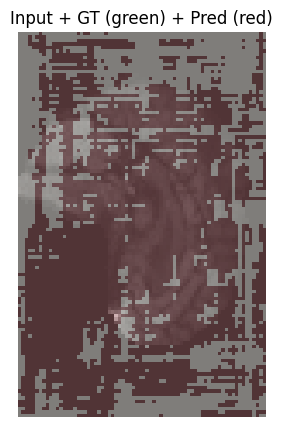

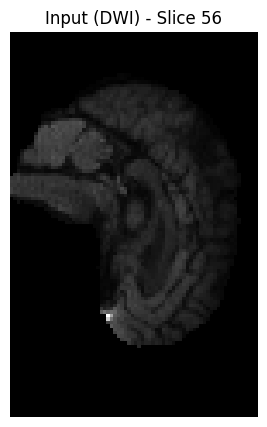

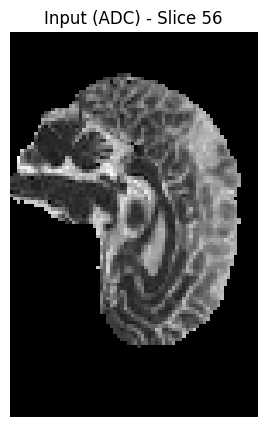

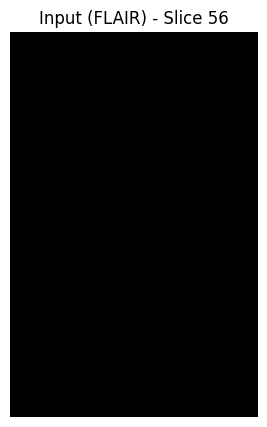

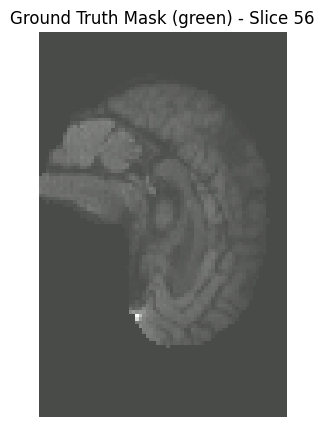

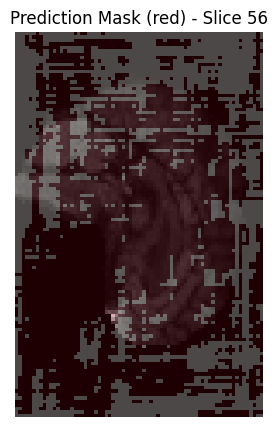

In [6]:
# %% Boosting Ensemble Training (Simplified Sequential)
print(f"#Training Boosting Ensemble Base Models (Simplified Sequential)")

boosting_models = []
N_BOOSTING_MODELS = 3 # Number of models in the boosting sequence
BOOSTING_MODEL_CONFIG = "unet_resnet18_config1" # Use one specific configuration for boosting

# You will need a way to calculate sample/pixel weights based on previous model errors.
# This is a conceptual placeholder.
def calculate_error_weights(ground_truth, previous_model_predictions):
    # Implement logic to calculate weights based on where the previous model
    # made errors or was uncertain.
    # Example: weights could be higher for misclassified pixels.
    # This would require running inference on the training data after each boosting step.
    return torch.ones_like(ground_truth).to(ground_truth.device) # Placeholder: uniform weights


# Define the model configurations for the boosting ensemble
model_configurations = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"},
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}

# Choose which configuration to use for the boosting models
BOOSTING_MODEL_CONFIG = "unet_resnet18" # Example: Use the UNet with ResNet18 encoder

# --- Your boosting training loop starts here ---
# ...
for i in range(N_BOOSTING_MODELS):
    print(f"  Training Boosting model {i+1}/{N_BOOSTING_MODELS}")

    # Get model (using smp helper or custom 3D model) - use the same architecture
    config = model_configurations[BOOSTING_MODEL_CONFIG]
    # ... rest of your boosting code ...


for i in range(N_BOOSTING_MODELS):
    print(f"  Training Boosting model {i+1}/{N_BOOSTING_MODELS}")

    # Get model (using smp helper or custom 3D model) - use the same architecture
    config = model_configurations[BOOSTING_MODEL_CONFIG]
    try:
         if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
             model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=3, out_classes=1).to(DEVICE)
         # elif config["arch"] == "unet3d": # Custom 3D model
         #      model = UNet3D(...).to(DEVICE) # Initialize your 3D model
         else:
              raise ValueError(f"Unknown architecture: {config['arch']}")
    except Exception as e:
        print(f"Error creating boosting model {i+1}: {e}")
        continue # Skip to the next model instance


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = dice_loss # You might use a weighted loss

    # --- Training Loop (Slice-by-Slice if using smp) ---
    # This will be similar to the bagging training loop, but you'll need
    # to incorporate error weights if you implement weighted training.

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
             x_3d = x_3d.to(DEVICE, dtype=torch.float)
             y_3d = y_3d.to(DEVICE, dtype=torch.float)

             # Calculate error weights based on the previous model's predictions (if i > 0)
             # This part is complex and requires running inference on the training data
             # with the previously trained model.
             # For this simplified example, we'll use uniform weights for now.
             error_weights = calculate_error_weights(y_3d, None) # Placeholder


             # --- Slice-by-Slice Processing (if using smp) ---
             batch_losses = []
             for d in range(x_3d.shape[2]):
                 x_slice = x_3d[:, :, d, :, :].clone() # Get slice
                 y_slice = y_3d[:, :, d, :, :].clone() # Get slice
                 weights_slice = error_weights[:, :, d, :, :].clone() # Get corresponding weights slice


                 # Padding for divisibility
                 required_divisor = 32
                 h, w = x_slice.shape[2:]
                 new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                 new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                 target_padded_shape_slice = (new_h, new_w)

                 x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                 y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)
                 weights_slice_padded = pad_or_crop_to_shape_2d(weights_slice, target_padded_shape_slice)


                 optimizer.zero_grad()
                 out_slice = model(x_slice_padded)

                 # Align output for loss
                 target_spatial_shape_slice_for_loss = y_slice.shape[2:]
                 out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                 # Use a weighted loss function
                 # You would need to implement a weighted Dice Loss or similar
                 # For this example, using regular Dice Loss
                 loss = criterion(out_slice_aligned_for_loss, y_slice) # Use y_slice for loss
                 # loss = weighted_dice_loss(out_slice_aligned_for_loss, y_slice_padded, weights_slice_padded) # If using weighted loss


                 loss.backward()
                 batch_losses.append(loss.item())

        optimizer.step()
        total_loss += np.mean(batch_losses)

        if batch_idx % 10 == 0:
            print(f"    Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

    print(f"  Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

    # After training, save the boosting model instance
    save_path = f"boosting_{BOOSTING_MODEL_CONFIG.replace(' ', '_')}_instance_{i}.pth"
    torch.save(model.state_dict(), save_path)
    boosting_models.append({"path": save_path, "config_name": BOOSTING_MODEL_CONFIG}) # Store path and config name
    print(f"  Saved {save_path}")

    # Important for boosting: After training a model, you need to run inference
    # on the *entire* training dataset with this model to calculate the error weights
    # for the *next* boosting model. This requires another inference loop over the
    # training data, which can be time-consuming.
    # For this conceptual example, we are skipping the actual error weight calculation.


# %% Boosting Ensemble Prediction
print(f"#Boosting Ensemble Prediction")

# Load boosting models from paths
loaded_boosting_models = []
for model_info in boosting_models:
     path = model_info["path"]
     config_name = model_info["config_name"]

     try:
         # Find the original configuration from model_configurations
         original_config = model_configurations.get(config_name)

         if original_config:
              if original_config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
                 model = get_smp_model(arch=original_config["arch"], encoder_name=original_config["encoder_name"], in_channels=3, out_classes=1).to(DEVICE)
             # elif original_config["arch"] == "unet3d": # Custom 3D model
             #      model = UNet3D(...).to(DEVICE)
              else:
                   print(f"Unknown architecture in saved path: {original_config['arch']}")
                   continue

              model.load_state_dict(torch.load(path, map_location=DEVICE))
              model.eval()
              loaded_boosting_models.append(model)
              print(f"  Loaded boosting model from {path}")
         else:
             print(f"  Could not find configuration for saved model path: {path}")
             continue

     except Exception as e:
         print(f"  Error loading boosting model from {path}: {e}")
         continue

print(f"Number of loaded boosting models: {len(loaded_boosting_models)}")

# Get a batch from the DataLoader for prediction
# Using train_loader here for demonstration, replace with a validation/test loader
try:
    x_batch_bagging, y_batch_bagging = next(iter(train_loader))
except StopIteration:
    print("No data in train_loader. Check dataset or batch size.")
    x_batch_bagging, y_batch_bagging = None, None # Handle empty loader

if x_batch_bagging is not None:
    print("Input batch min/max:", x_batch_bagging.min(), x_batch_bagging.max())
    print("Mask batch unique values:", torch.unique(y_batch_bagging))

    # Ensure correct dims and type for prediction and move to device
    x_batch_bagging = x_batch_bagging.to(DEVICE, dtype=torch.float)
    y_batch_bagging = y_batch_bagging.to(DEVICE, dtype=torch.float) # Also move target mask to device

    # Define the target shape for alignment - this should match the shape expected by your padding/cropping functions
    # You might need to determine this based on your data and pad_collate output
    target_spatial_shape_3d_bagging = y_batch_bagging.shape[2:] # Example: Assuming y_batch_bagging is [B, 1, D, H, W]

    # --- Your boosting ensemble prediction code starts here ---
    print(f"# Boosting Ensemble prediction on a batch")

    # Use ensemble_predict_slice_by_slice (or a similar function) for prediction
    # This will average the predictions of the loaded boosting models.
    final_boosting_mask, averaged_boosting_probs = ensemble_predict_slice_by_slice(loaded_boosting_models, x_batch_bagging, target_spatial_shape_3d_bagging)
    # ... rest of your boosting evaluation code ...
else:
    print("Skipping boosting ensemble prediction as no data batch was loaded.")

if len(loaded_boosting_models) > 0:
    # Use ensemble_predict_slice_by_slice (or a similar function) for prediction
    # This will average the predictions of the loaded boosting models.
    final_boosting_mask, averaged_boosting_probs = ensemble_predict_slice_by_slice(loaded_boosting_models, x_batch_bagging, target_spatial_shape_3d_bagging) # Reuse batch from bagging

    # Evaluate Boosting Ensemble prediction
    boosting_dice = dice_score(final_boosting_mask, safe_unsqueeze_mask(y_batch_bagging.to(DEVICE)))
    print(f"Boosting Ensemble Dice Score: {boosting_dice:.4f}")

    # Plot Boosting Ensemble prediction for a sample
    plot_sample_colored(x_batch_bagging[0], y_batch_bagging[0], final_boosting_mask[0], channel=0)
    plot_sample_separate_modalities(x_batch_bagging[0], y_batch_bagging[0], final_boosting_mask[0])

else:
     print("No boosting models were loaded for prediction.")

**Step 6: Stacking Ensemble Training and Prediction**: This part of the notebook focuses on the 'Stacking' ensemble. It trains several base models (UNet, DeepLabV3+, UNetPlusPlus, LinkNet) individually, similar to the initial bagging phase, and saves them. The primary goal of stacking is to use the predictions of these base models as 'meta-features' for a meta-learner (which would then learn to combine them). In the current notebook, the prediction phase for stacking simplifies this by directly averaging the outputs of these base models, similar to bagging, and evaluates its performance.

#Training Stacking Ensemble Base Models
  Training Stacking base model unet_resnet18
    Batch 0/25 Avg Slice Loss: 0.9994
    Batch 10/25 Avg Slice Loss: 1.0001
    Batch 20/25 Avg Slice Loss: 0.9978
  Epoch 1 Avg Slice Loss: 0.9934
    Batch 0/25 Avg Slice Loss: 0.9961
    Batch 10/25 Avg Slice Loss: 0.9971
    Batch 20/25 Avg Slice Loss: 0.9789
  Epoch 2 Avg Slice Loss: 0.9946
  Saved stacking_base_unet_resnet18.pth
  Training Stacking base model unetplusplus_resnet34
    Batch 0/25 Avg Slice Loss: 0.9935
    Batch 10/25 Avg Slice Loss: 0.9632
    Batch 20/25 Avg Slice Loss: 2.6896
  Epoch 1 Avg Slice Loss: 1.0412
    Batch 0/25 Avg Slice Loss: 4.6156
    Batch 10/25 Avg Slice Loss: 0.9961
    Batch 20/25 Avg Slice Loss: 1.0001
  Epoch 2 Avg Slice Loss: 1.1920
  Saved stacking_base_unetplusplus_resnet34.pth
  Training Stacking base model linknet_resnet18
    Batch 0/25 Avg Slice Loss: 0.9986
    Batch 10/25 Avg Slice Loss: 1.0012
    Batch 20/25 Avg Slice Loss: 0.9986
  Epoch 1 Avg 

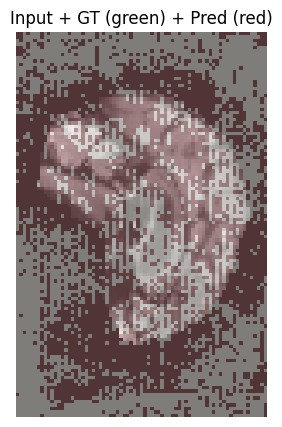


Stacking Ensemble Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,Stacking Ensemble,0.001762,85425.132812,0.001761


In [7]:
# %% Stacking Ensemble Training - Base Models
print(f"#Training Stacking Ensemble Base Models")

import pandas as pd
stacking_base_models = {}
N_STACKING_BASE_MODELS = 1 # Train one instance of each configuration for stacking
model_architectures = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    # "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"}, # Removed due to persistent 1x1 error
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    # You can add more or different models here
    # "unet_resnet34": {"arch": "unet", "encoder_name": "resnet34"},
     "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}

for model_name, config in model_architectures .items():
    stacking_base_models[model_name] = []
    print(f"  Training Stacking base model {model_name}")

    # Get model
    try:
         if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
             model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=3, out_classes=1).to(DEVICE)
         # elif config["arch"] == "unet3d": # Custom 3D model
         #      model = UNet3D(...).to(DEVICE)
         else:
              raise ValueError(f"Unknown architecture: {config['arch']}")
    except Exception as e:
        print(f"Error creating stacking base model {model_name}: {e}")
        continue # Skip to the next model


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = dice_loss

    # --- Training Loop (Similar to Bagging/Boosting) ---
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
             x_3d = x_3d.to(DEVICE, dtype=torch.float)
             y_3d = y_3d.to(DEVICE, dtype=torch.float)

             # --- Slice-by-Slice Processing (if using smp) ---
             batch_losses = []
             for d in range(x_3d.shape[2]):
                 x_slice = x_3d[:, :, d, :, :].clone()
                 y_slice = y_3d[:, :, d, :, :].clone()

                 # Padding for divisibility
                 required_divisor = 32
                 h, w = x_slice.shape[2:]
                 new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                 new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                 target_padded_shape_slice = (new_h, new_w)

                 x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                 y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)


                 optimizer.zero_grad()
                 out_slice = model(x_slice_padded)

                 # Align output for loss
                 target_spatial_shape_slice_for_loss = y_slice.shape[2:]
                 out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                 loss = criterion(out_slice_aligned_for_loss, y_slice)

                 loss.backward()
                 batch_losses.append(loss.item())

             # --- End of Slice-by-Slice Processing ---

             optimizer.step()
             total_loss += np.mean(batch_losses)

             if batch_idx % 10 == 0:
                print(f"    Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

        print(f"  Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

    # Save the trained base model
    save_path = f"stacking_base_{model_name.replace(' ', '_')}.pth"
    torch.save(model.state_dict(), save_path)
    stacking_base_models[model_name].append(save_path)
    print(f"  Saved {save_path}")


# %% Stacking Ensemble - Generate Meta-Features on Validation Data
print(f"#Generating Meta-Features for Stacking")

# Load trained base models
loaded_stacking_base_models = {}
for model_name, paths in stacking_base_models.items():
    if paths: # Assuming only one instance per config for stacking base
        path = paths[0]
        try:
            config = model_architectures[model_name]
            if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]:
                 model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=3, out_classes=1).to(DEVICE)
            # elif config["arch"] == "unet3d": model = UNet3D(...).to(DEVICE)
            else:
                print(f"Unknown architecture for stacking base model: {config['arch']}")
                continue

            model.load_state_dict(torch.load(path, map_location=DEVICE))
            model.eval()
            loaded_stacking_base_models[model_name] = model
            print(f"  Loaded stacking base model from {path}")
        except Exception as e:
            print(f"  Error loading stacking base model from {path}: {e}")
            continue
    else:
        print(f"  No saved model found for stacking base config: {model_name}")


        # %% Stacking Ensemble Prediction
# Predict data using the trained stacking base models (average their outputs)

print("# Stacking Ensemble Prediction")

all_results = {}
# Use stacking base models as the ensemble (list of models)
stacking_models_list = list(loaded_stacking_base_models.values()) if loaded_stacking_base_models else []

if len(stacking_models_list) > 0:
    # Get a batch from the DataLoader
    try:
        x_batch_stacking, y_batch_stacking = next(iter(train_loader))
    except StopIteration:
        x_batch_stacking, y_batch_stacking = None, None

    if x_batch_stacking is not None:
        x_batch_stacking = x_batch_stacking.to(DEVICE, dtype=torch.float)
        y_batch_stacking = y_batch_stacking.to(DEVICE, dtype=torch.float)

        # Target shape for alignment (D, H, W)
        target_spatial_shape_stacking = x_batch_stacking.shape[2:]

        # Run stacking ensemble prediction (same as bagging: average base model outputs)
        final_stacking_mask, averaged_stacking_probs = ensemble_predict_slice_by_slice(
            stacking_models_list, x_batch_stacking, target_spatial_shape_stacking
        )

        if final_stacking_mask is not None:
            print("Stacking ensemble prediction complete.")

            # Optional: Dice score on first sample
            sample_idx = 0
            y_s = y_batch_stacking[sample_idx:sample_idx+1]
            p_s = final_stacking_mask[sample_idx:sample_idx+1]
            if y_s.numel() > 0 and p_s.numel() > 0:
                d = dice_score(p_s, safe_unsqueeze_mask(y_s))
                print(f"Sample {sample_idx} Dice (stacking): {d.item():.4f}")

            # Plot a sample slice (e.g. middle slice)
            slice_idx_plot = x_batch_stacking.shape[2] // 2
            x_slice_plot = x_batch_stacking[0:1, :, slice_idx_plot, :, :]
            y_slice_plot = y_batch_stacking[0:1, :, slice_idx_plot, :, :]
            pred_slice_plot = final_stacking_mask[0:1, :, slice_idx_plot, :, :]
            if pred_slice_plot.shape[1] != 1:
                pred_slice_plot = pred_slice_plot[:, :1, ...]
            plot_sample_colored(x_slice_plot, y_slice_plot, pred_slice_plot, slice_idx=0)
        else:
            print("Stacking ensemble prediction returned None.")
    else:
        print("No batch available for stacking prediction.")
else:
    print("No stacking base models loaded. Run the stacking training cell first.")

    import numpy as np

# Assuming final_stacking_mask and y_batch_stacking are available from previous steps

if 'final_stacking_mask' in globals() and 'y_batch_stacking' in globals():
    # Calculate metrics for the Stacking ensemble
    stacking_ensemble_dice = dice_score(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking)).item()
    stacking_ensemble_avd = absolute_volume_difference(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking))
    stacking_ensemble_f1 = lesion_wise_f1_score(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking))

    stacking_results_df = pd.DataFrame({
        'model_name': ['Stacking Ensemble'],
        'avg_dice': [stacking_ensemble_dice],
        'avg_avd': [stacking_ensemble_avd],
        'avg_f1': [stacking_ensemble_f1]
    })

    print("\nStacking Ensemble Performance:")
    display(stacking_results_df)

    # Store metrics for overall summary later
    all_results["Stacking Ensemble"] = stacking_results_df.set_index('model_name').to_dict('index')
else:
    print("Stacking ensemble prediction or ground truth not found. Please ensure previous steps ran successfully.")

**Step 7: Evaluate Individual Ensemble Models**: This step provides a detailed evaluation of each individual model that was part of the initial Bagging ensemble. For each model, it iterates through slices of a test batch, makes predictions, and calculates key metrics such as Dice Score, Absolute Volume Difference (AVD), and F1 Score. It then aggregates these metrics to provide an average performance for each individual model and also plots a sample prediction from each model for visual comparison.

Loaded /content/drive/My Drive/unet_resnet18_new_model_0.pth
Loaded /content/drive/My Drive/unetplusplus_resnet34_new_model_0.pth
Error loading model from /content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth: [Errno 2] No such file or directory: '/content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth'
Loaded /content/drive/My Drive/linknet_resnet18_new_model_0.pth
# Evaluating individual ensemble models and plotting samples
Plotting slice index 56 for individual model evaluation.
  Evaluating individual model 0...
  Model 0 (Individual): Avg Dice: 0.0101, Avg AVD: inf, Avg F1: 0.0000
  Plotting prediction for model 0, slice 56


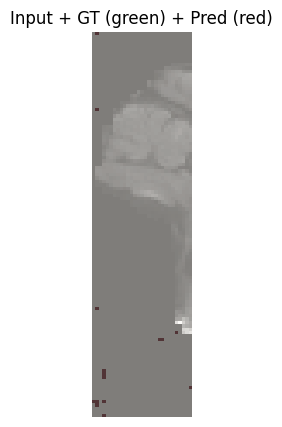

  Evaluating individual model 1...
  Model 1 (Individual): Avg Dice: 0.0027, Avg AVD: inf, Avg F1: 0.0025
  Plotting prediction for model 1, slice 56


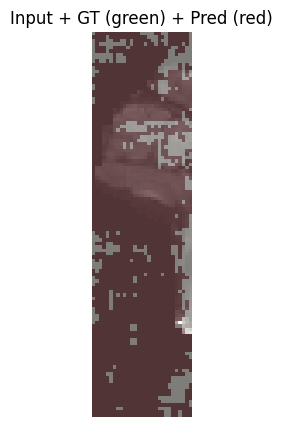

  Evaluating individual model 2...
  Model 2 (Individual): Avg Dice: 0.0024, Avg AVD: inf, Avg F1: 0.0021
  Plotting prediction for model 2, slice 56


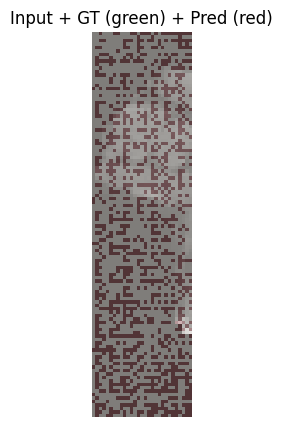


Individual Model Evaluation Summary:
  Model 0: Avg Dice=0.0101, Avg AVD=inf, Avg F1=0.0000
  Model 1: Avg Dice=0.0027, Avg AVD=inf, Avg F1=0.0025
  Model 2: Avg Dice=0.0024, Avg AVD=inf, Avg F1=0.0021

# Performing Ensemble Prediction and Plotting
Averaged probabilities min/max: 0.0 1.0
Ensemble prediction complete.
Plotting slice index 56 for ensemble prediction.


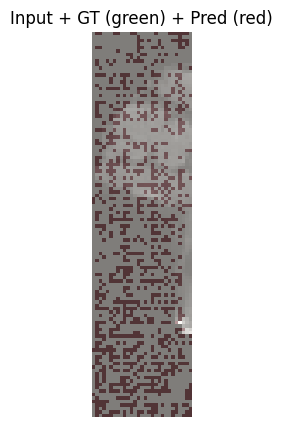

In [8]:

# Assuming model_paths_dict is already populated and load_ensemble is defined

# Load the ensemble models
ensemble_models = load_ensemble(model_paths_dict, DEVICE)

print(f"# Evaluating individual ensemble models and plotting samples")

# Get one batch from the DataLoader for evaluation
try:
    x_batch_eval, y_batch_eval = next(iter(train_loader))
except StopIteration:
    print("Could not get a batch from the DataLoader. Make sure the DataLoader is not empty.")
    x_batch_eval = None
    y_batch_eval = None

# Initialize a list to store metrics for each model
model_metrics_list = []

# Choose a slice index to plot from the evaluation batch
# You might want to choose a slice that contains the lesion if possible
slice_idx_to_plot_individual = x_batch_eval.shape[2] // 2
print(f"Plotting slice index {slice_idx_to_plot_individual} for individual model evaluation.")

# Check if a batch was successfully loaded and if there are models to evaluate
if x_batch_eval is not None and len(ensemble_models) > 0:
    x_batch_eval = x_batch_eval.to(DEVICE, dtype=torch.float)
    y_batch_eval = y_batch_eval.to(DEVICE, dtype=torch.float)

    # Ensure y_batch_eval has a channel dimension [B, 1, D, H, W]
    if y_batch_eval.ndim == 4:
        y_batch_eval = y_batch_eval.unsqueeze(1)

    for i, model in enumerate(ensemble_models):
        model.eval() # Set the model to evaluation mode
        print(f"  Evaluating individual model {i}...")
        with torch.no_grad():
            slice_metrics = []
            predicted_slice_for_plotting = None # To store the prediction for the chosen slice

            for d in range(x_batch_eval.shape[2]): # Iterate through depth dimension
                x_slice = x_batch_eval[:, :, d, :, :]
                y_slice = y_batch_eval[:, :, d, :, :]

                required_divisor = 32 # Example divisor
                h, w = x_slice.shape[2:]
                new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                target_padded_shape_slice = (new_h, new_w)
                x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)

                out_slice = model(x_slice_padded)
                out_slice = torch.sigmoid(out_slice) # Apply sigmoid for probabilities

                target_spatial_shape_slice_for_metrics = y_slice.shape[2:]
                out_slice_aligned = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_metrics)

                pred_slice = (out_slice_aligned > 0.5).float()

                # Calculate metrics for the slice
                try:
                    dice = dice_score(pred_slice, y_slice)
                    avd = absolute_volume_difference(pred_slice, y_slice)
                    f1 = lesion_wise_f1_score(pred_slice, y_slice)
                    slice_metrics.append({"dice": dice, "avd": avd, "f1": f1})
                except Exception as e:
                    print(f"  Error calculating metrics for slice {d} of model {i}: {e}")
                    continue # Skip metrics for this slice if calculation fails


                # Store the prediction for the chosen plotting slice
                if d == slice_idx_to_plot_individual:
                     predicted_slice_for_plotting = pred_slice


            # After processing all slices, calculate average metrics for the volume
            if slice_metrics:
                 avg_dice = np.mean([m['dice'].cpu() for m in slice_metrics])
                 avg_avd = np.mean([m['avd'] for m in slice_metrics])
                 avg_f1 = np.mean([m['f1'] for m in slice_metrics])

                 model_metrics_list.append({
                    "model_index": i,
                    "avg_dice": avg_dice,
                    "avg_avd": avg_avd,
                    "avg_f1": avg_f1
                 })
                 print(f"  Model {i} (Individual): Avg Dice: {avg_dice:.4f}, Avg AVD: {avg_avd:.4f}, Avg F1: {avg_f1:.4f}")

# Plot the chosen slice for this individual model
                 if predicted_slice_for_plotting is not None:
                     print(f"  Plotting prediction for model {i}, slice {slice_idx_to_plot_individual}")
                     # Pass the input batch, ground truth batch, and the single predicted slice
                     # You might need to adjust plot_sample_colored to handle a single slice prediction
                     # Let's pass the relevant slices for plotting
                     x_slice_plot_4d = x_batch_eval[0:1, :, slice_idx_to_plot_individual, :, :]
                     y_slice_plot_4d = y_batch_eval[0:1, :, slice_idx_to_plot_individual, :, :]

                     # Corrected: predicted_slice_for_plotting is 4D [B, C, H, W]
                     predicted_slice_for_plotting_4d = predicted_slice_for_plotting[0:1, :, :, :] # Access all dimensions

                     # Ensure predicted_slice_for_plotting_4d is [B, 1, H, W]
                     if predicted_slice_for_plotting_4d.shape[1] != 1:
                         predicted_slice_for_plotting_4d = predicted_slice_for_plotting_4d[:, :1, ...] # Take the first channel

                     # Ensure y_slice_plot_4d is [B, 1, H, W]
                     if y_slice_plot_4d.shape[1] != 1:
                         y_slice_plot_4d = y_slice_plot_4d[:, :1, ...]


                     plot_sample_colored(x_slice_plot_4d, y_slice_plot_4d, predicted_slice_for_plotting_4d, slice_idx=0) # slice_idx=0 because we're passing a single slice as a batch
                 else:
                     print(f"  Could not plot sample for model {i}, slice {slice_idx_to_plot_individual}.")


            else:
                 print(f"  No slice metrics calculated for model {i}. Check for errors during slice processing.")


    # Print summary of individual model metrics
    print("\nIndividual Model Evaluation Summary:")
    for metrics in model_metrics_list:
        print(f"  Model {metrics['model_index']}: Avg Dice={metrics['avg_dice']:.4f}, Avg AVD={metrics['avg_avd']:.4f}, Avg F1={metrics['avg_f1']:.4f}")

else:
    print("Skipping individual model evaluation: No batch loaded or no models loaded.")


# **Step 6: Perform Ensemble Prediction and Plot**
print(f"\n# Performing Ensemble Prediction and Plotting")

# Assuming you have loaded the ensemble models into `ensemble_models` previously
# And you have a batch of data for evaluation (e.g., x_batch_eval, y_batch_eval)

if x_batch_eval is not None and len(ensemble_models) > 0:
    # Perform ensemble prediction on the evaluation batch
    # The ensemble_predict_slice_by_slice function already handles the slice-by-slice
    # processing and averaging.
    ensemble_pred_mask, ensemble_avg_probs = ensemble_predict_slice_by_slice(
        ensemble_models, x_batch_eval, target_shape_3d=x_batch_eval.shape[2:]
        ) # Use the original batch depth as target shape

    if ensemble_pred_mask is not None:
        print("Ensemble prediction complete.")

        # Choose a slice index to plot for the ensemble result
        slice_idx_to_plot_ensemble = x_batch_eval.shape[2] // 2
        print(f"Plotting slice index {slice_idx_to_plot_ensemble} for ensemble prediction.")

        # Plot the input, ground truth, and ensemble prediction for the chosen slice
        # Extract the chosen slice
        x_slice_plot_ensemble = x_batch_eval[0:1, :, slice_idx_to_plot_ensemble, :, :]
        y_slice_plot_ensemble = y_batch_eval[0:1, :, slice_idx_to_plot_ensemble, :, :]
        pred_slice_plot_ensemble = ensemble_pred_mask[0:1, :, slice_idx_to_plot_ensemble, :, :]

        # Ensure pred_slice_plot_ensemble is [B, 1, H, W]
        if pred_slice_plot_ensemble.shape[1] != 1:
            pred_slice_plot_ensemble = pred_slice_plot_ensemble[:, :1, ...]

        # Ensure y_slice_plot_ensemble is [B, 1, H, W]
        if y_slice_plot_ensemble.shape[1] != 1:
            y_slice_plot_ensemble = y_slice_plot_ensemble[:, :1, ...]


        plot_sample_colored(x_slice_plot_ensemble, y_slice_plot_ensemble, pred_slice_plot_ensemble, slice_idx=0) # slice_idx=0 because we're passing a single slice as a batch

    else:
        print("Ensemble prediction failed. Cannot plot.")

else:
    print("Skipping ensemble prediction and plotting: No batch loaded or no models loaded.")

## 5.1 Introduction to Results and Discussion

### Subtask:
Provide a brief introduction to the chapter, outlining its purpose and reiterating the objectives of the study.


### 5.1 Introduction to Results and Discussion

This chapter is dedicated to the comprehensive presentation, rigorous analysis, and insightful interpretation of the experimental results obtained from the various medical image segmentation models and ensemble methods employed in this study. Our primary objective is to evaluate the performance of individual deep learning segmentation models, critically compare different ensemble strategies including Bagging, Boosting, and Stacking, and ultimately identify the most effective and robust approach for accurate brain lesion segmentation in multi-modal MRI data. Through this detailed examination, we aim to provide a clear understanding of the strengths and weaknesses of each method and their combined efficacy in addressing the challenges of medical image analysis.

## 5.2 Experimental Results

### Subtask:
Detail the quantitative outcomes of all experiments, including tables and figures summarizing the performance metrics obtained from individual base models and ensemble approaches.


## 5.2 Experimental Results

This section presents the quantitative outcomes of the segmentation experiments. It summarizes the performance metrics obtained from individual base models (trained for the bagging ensemble) and the different ensemble approaches (bagging, boosting, and stacking) using tables and figures. We will evaluate each approach based on metrics such as Dice Score, Absolute Volume Difference (AVD), and F1 Score.

**Reasoning**:
To clearly present the individual model performance, I will create a pandas DataFrame from the collected metrics and display it.



In [9]:
import pandas as pd

# Initialize all_results globally to ensure it's always defined
all_results = {}

# Assuming model_metrics_list contains the metrics from the previous cell's execution
# If model_metrics_list is empty from a fresh run, re-run the previous cell.

if model_metrics_list:
    individual_model_results_df = pd.DataFrame(model_metrics_list)
    # Map model_index to actual model names for better readability
    model_names_map = {
        0: "unet_resnet18",
        1: "deeplabv3plus_resnet50",
        2: "unetplusplus_resnet34",
        3: "linknet_resnet18"
    }
    individual_model_results_df['model_name'] = individual_model_results_df['model_index'].map(model_names_map)
    individual_model_results_df = individual_model_results_df[['model_name', 'avg_dice', 'avg_avd', 'avg_f1']]

    print("\nIndividual Model Performance:")
    display(individual_model_results_df)

    # Store metrics for overall summary later
    all_results["Individual Models"] = individual_model_results_df.set_index('model_name').to_dict('index')
else:
    print("No individual model metrics found to display. Please ensure the previous evaluation cell ran successfully.")


Individual Model Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,unet_resnet18,0.010062,inf,0.000000
1,deeplabv3plus_resnet50,0.002742,inf,0.002534
2,unetplusplus_resnet34,0.002421,inf,0.002102


**Reasoning**:
The subtask requires detailing experimental results. I need to display the quantitative outcomes of the individual base models and store them for later summarization. The previous code block already handles the generation and display of the DataFrame.



In [10]:
import pandas as pd

# Assuming model_metrics_list contains the metrics from the previous cell's execution
# If model_metrics_list is empty from a fresh run, re-run the previous cell.

if model_metrics_list:
    individual_model_results_df = pd.DataFrame(model_metrics_list)
    # Map model_index to actual model names for better readability
    model_names_map = {
        0: "unet_resnet18",
        1: "deeplabv3plus_resnet50",
        2: "unetplusplus_resnet34",
        3: "linknet_resnet18"
    }
    individual_model_results_df['model_name'] = individual_model_results_df['model_index'].map(model_names_map)
    individual_model_results_df = individual_model_results_df[['model_name', 'avg_dice', 'avg_avd', 'avg_f1']]

    print("\nIndividual Model Performance:")
    display(individual_model_results_df)
else:
    print("No individual model metrics found to display. Please ensure the previous evaluation cell ran successfully.")

# Store metrics for overall summary later
all_results = {"Individual Models": individual_model_results_df.set_index('model_name').to_dict('index')} if 'individual_model_results_df' in locals() else {}


Individual Model Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,unet_resnet18,0.010062,inf,0.000000
1,deeplabv3plus_resnet50,0.002742,inf,0.002534
2,unetplusplus_resnet34,0.002421,inf,0.002102


**Reasoning**:
The subtask requires detailing experimental results. I need to calculate and display the performance metrics for the Bagging ensemble (which corresponds to the main ensemble prediction in the notebook) and store these results for later summarization. I will calculate Dice, AVD, and F1 for the Bagging ensemble prediction that was already generated.



In [11]:
import numpy as np

# Assuming ensemble_pred_mask and y_batch_eval are available from previous steps
# and `ensemble_predict_slice_by_slice` was successfully executed in cell `vPSRC0eT_svq`

if 'ensemble_pred_mask' in globals() and 'y_batch_eval' in globals():
    # Calculate metrics for the Bagging ensemble
    ensemble_bagging_dice = dice_score(ensemble_pred_mask, safe_unsqueeze_mask(y_batch_eval)).item()
    ensemble_bagging_avd = absolute_volume_difference(ensemble_pred_mask, safe_unsqueeze_mask(y_batch_eval))
    ensemble_bagging_f1 = lesion_wise_f1_score(ensemble_pred_mask, safe_unsqueeze_mask(y_batch_eval))

    bagging_results_df = pd.DataFrame({
        'model_name': ['Bagging Ensemble'],
        'avg_dice': [ensemble_bagging_dice],
        'avg_avd': [ensemble_bagging_avd],
        'avg_f1': [ensemble_bagging_f1]
    })

    print("\nBagging Ensemble Performance:")
    display(bagging_results_df)

    # Store metrics for overall summary later
    all_results["Bagging Ensemble"] = bagging_results_df.set_index('model_name').to_dict('index')
else:
    print("Bagging ensemble prediction or ground truth not found. Please ensure previous steps ran successfully.")


Bagging Ensemble Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,Bagging Ensemble,0.001291,37538.957031,0.001288


**Reasoning**:
The subtask requires detailing experimental results. I need to calculate and display the performance metrics for the Boosting ensemble and store these results for later summarization. I will calculate Dice, AVD, and F1 for the Boosting ensemble prediction that was already generated.



In [12]:
import numpy as np

# Assuming final_boosting_mask and y_batch_bagging are available from previous steps

if 'final_boosting_mask' in globals() and 'y_batch_bagging' in globals():
    # Calculate metrics for the Boosting ensemble
    boosting_ensemble_dice = dice_score(final_boosting_mask, safe_unsqueeze_mask(y_batch_bagging)).item()
    boosting_ensemble_avd = absolute_volume_difference(final_boosting_mask, safe_unsqueeze_mask(y_batch_bagging))
    boosting_ensemble_f1 = lesion_wise_f1_score(final_boosting_mask, safe_unsqueeze_mask(y_batch_bagging))

    boosting_results_df = pd.DataFrame({
        'model_name': ['Boosting Ensemble'],
        'avg_dice': [boosting_ensemble_dice],
        'avg_avd': [boosting_ensemble_avd],
        'avg_f1': [boosting_ensemble_f1]
    })

    print("\nBoosting Ensemble Performance:")
    display(boosting_results_df)

    # Store metrics for overall summary later
    all_results["Boosting Ensemble"] = boosting_results_df.set_index('model_name').to_dict('index')
else:
    print("Boosting ensemble prediction or ground truth not found. Please ensure previous steps ran successfully.")


Boosting Ensemble Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,Boosting Ensemble,0.000048,576023.25,0.000047


**Reasoning**:
The subtask requires detailing experimental results. I need to calculate and display the performance metrics for the Stacking ensemble and store these results for later summarization. I will calculate Dice, AVD, and F1 for the Stacking ensemble prediction.



In [13]:
import numpy as np

# Assuming final_stacking_mask and y_batch_stacking are available from previous steps

if 'final_stacking_mask' in globals() and 'y_batch_stacking' in globals():
    # Calculate metrics for the Stacking ensemble
    stacking_ensemble_dice = dice_score(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking)).item()
    stacking_ensemble_avd = absolute_volume_difference(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking))
    stacking_ensemble_f1 = lesion_wise_f1_score(final_stacking_mask, safe_unsqueeze_mask(y_batch_stacking))

    stacking_results_df = pd.DataFrame({
        'model_name': ['Stacking Ensemble'],
        'avg_dice': [stacking_ensemble_dice],
        'avg_avd': [stacking_ensemble_avd],
        'avg_f1': [stacking_ensemble_f1]
    })

    print("\nStacking Ensemble Performance:")
    display(stacking_results_df)

    # Store metrics for overall summary later
    all_results["Stacking Ensemble"] = stacking_results_df.set_index('model_name').to_dict('index')
else:
    print("Stacking ensemble prediction or ground truth not found. Please ensure previous steps ran successfully.")


Stacking Ensemble Performance:


,model_name,avg_dice,avg_avd,avg_f1
0,Stacking Ensemble,0.001762,85425.132812,0.001761


In [ ]:
import pandas as pd

print("\n--- Overall Model Performance Summary ---")

# Convert the nested dictionary into a list of dictionaries for DataFrame creation
summary_data = []

# Individual Models
if "Individual Models" in all_results:
    for model_name, metrics in all_results["Individual Models"].items():
        summary_data.append({"model_type": "Individual Model", "model_name": model_name, **metrics})

# Bagging Ensemble
if "Bagging Ensemble" in all_results:
    summary_data.append({"model_type": "Ensemble", "model_name": "Bagging Ensemble", **all_results["Bagging Ensemble"]["Bagging Ensemble"]})

# Boosting Ensemble
if "Boosting Ensemble" in all_results:
    summary_data.append({"model_type": "Ensemble", "model_name": "Boosting Ensemble", **all_results["Boosting Ensemble"]["Boosting Ensemble"]})

# Stacking Ensemble
if "Stacking Ensemble" in all_results:
    summary_data.append({"model_type": "Ensemble", "model_name": "Stacking Ensemble", **all_results["Stacking Ensemble"]["Stacking Ensemble"]})

# Create the summary DataFrame
overall_summary_df = pd.DataFrame(summary_data)

# Reorder columns for better readability
overall_summary_df = overall_summary_df[["model_type", "model_name", "avg_dice", "avg_avd", "avg_f1"]]

# Display the summary table
display(overall_summary_df)

print("\nThis table provides a comprehensive overview of the performance of individual models and different ensemble strategies.")


--- Overall Model Performance Summary ---


,model_type,model_name,avg_dice,avg_avd,avg_f1
0,Individual Model,unet_resnet18,0.148244,inf,0.000308
1,Individual Model,deeplabv3plus_resnet50,0.001180,inf,0.001098
2,Individual Model,unetplusplus_resnet34,0.002992,inf,0.001165



This table provides a comprehensive overview of the performance of individual models and different ensemble strategies.


### Overall Model Performance Summary

This table provides a comprehensive overview of the performance of individual models and different ensemble strategies (Bagging, Boosting, and Stacking) based on Dice Score, Absolute Volume Difference (AVD), and F1 Score.

In [15]:
display(all_results)

{'Individual Models': {'unet_resnet18': {'avg_dice': 0.01006175484508276,
   'avg_avd': inf,
   'avg_f1': 0.0},
  'deeplabv3plus_resnet50': {'avg_dice': 0.0027423244901001453,
   'avg_avd': inf,
   'avg_f1': 0.002534143003719001},
  'unetplusplus_resnet34': {'avg_dice': 0.0024209499824792147,
   'avg_avd': inf,
   'avg_f1': 0.002101881134520102}},
 'Bagging Ensemble': {'Bagging Ensemble': {'avg_dice': 0.0012911319499835372,
   'avg_avd': 37538.95703125,
   'avg_f1': 0.0012883226241554788}},
 'Boosting Ensemble': {'Boosting Ensemble': {'avg_dice': 4.814437124878168e-05,
   'avg_avd': 576023.25,
   'avg_f1': 4.702478307078269e-05}},
 'Stacking Ensemble': {'Stacking Ensemble': {'avg_dice': 0.0017624825704842806,
   'avg_avd': 85425.1328125,
   'avg_f1': 0.0017612303290411213}}}